In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import ttidelib as tt
import subprocess
import os
from importlib import reload
import xrft 
%matplotlib inline
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39407,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:34889,Total threads: 4
Dashboard: /proxy/41335/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:41171,


## Load the along beam data

In [2]:
output = "008"
eta = tt.beamgrid(xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-20/output{output}/surface.nc",decode_times = False).zos)
speed = tt.beamgrid(xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-20/output{output}/surface.nc",decode_times = False).speed)
u = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-20/output{output}/u/*",decode_times = False).u
v = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-20/output{output}/v/*",decode_times = False).v
e = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-20/output{output}/e/*",decode_times = False).e
rho = xr.open_mfdataset(f"/g/data/nm03/ab8992/outputs/full-20/output{output}/rho/*",decode_times = False).rho
bathy = tt.beamgrid(xr.open_mfdataset(f"/g/data/nm03/ab8992/ttide-inputs/full-20/topog_raw.nc",decode_times = False).elevation,xname = "lon",yname = "lat")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yh', 'xh') from data variable zos as the horizontal dimensions for the regridding.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xesmf/frontend.py:696: UserWarning: Using dimensions ('yh', 'xh') from data variable speed as the horizontal dimensions for the regridding.
  warnings.warn(


In [53]:
data.time.values[10]

2891.0

In [91]:
reload(tt)
data = xr.Dataset(
    {"speed":speed.rename({"time":"TIME"}), ## Rename since this dimension is on 6hrs
            "u":u.isel(time = slice(20,25)),
            "v":v.isel(time = slice(20,25)),
            "bathy":bathy
    }
)

data

fig = plt.figure(figsize=(15, 12))

# tt.plot_hef(data,fig,50)
tt.make_movie(data,tt.plot_hef,fig,"full-20","test")

Making movie and writing to /g/data/v45/ab8992/dropbox/tasman-tides/full-20/movies/test/


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2026: UserWarning: The following kwargs were not used by contour: 'lineweight'
  primitive = ax.contour(x, y, z, **kwargs)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xmovie/core.py:348: Use

RuntimeError: Something has gone wrong. Use `verbose=True` to check if ffmpeg displays a problem

<Figure size 1500x1200 with 0 Axes>

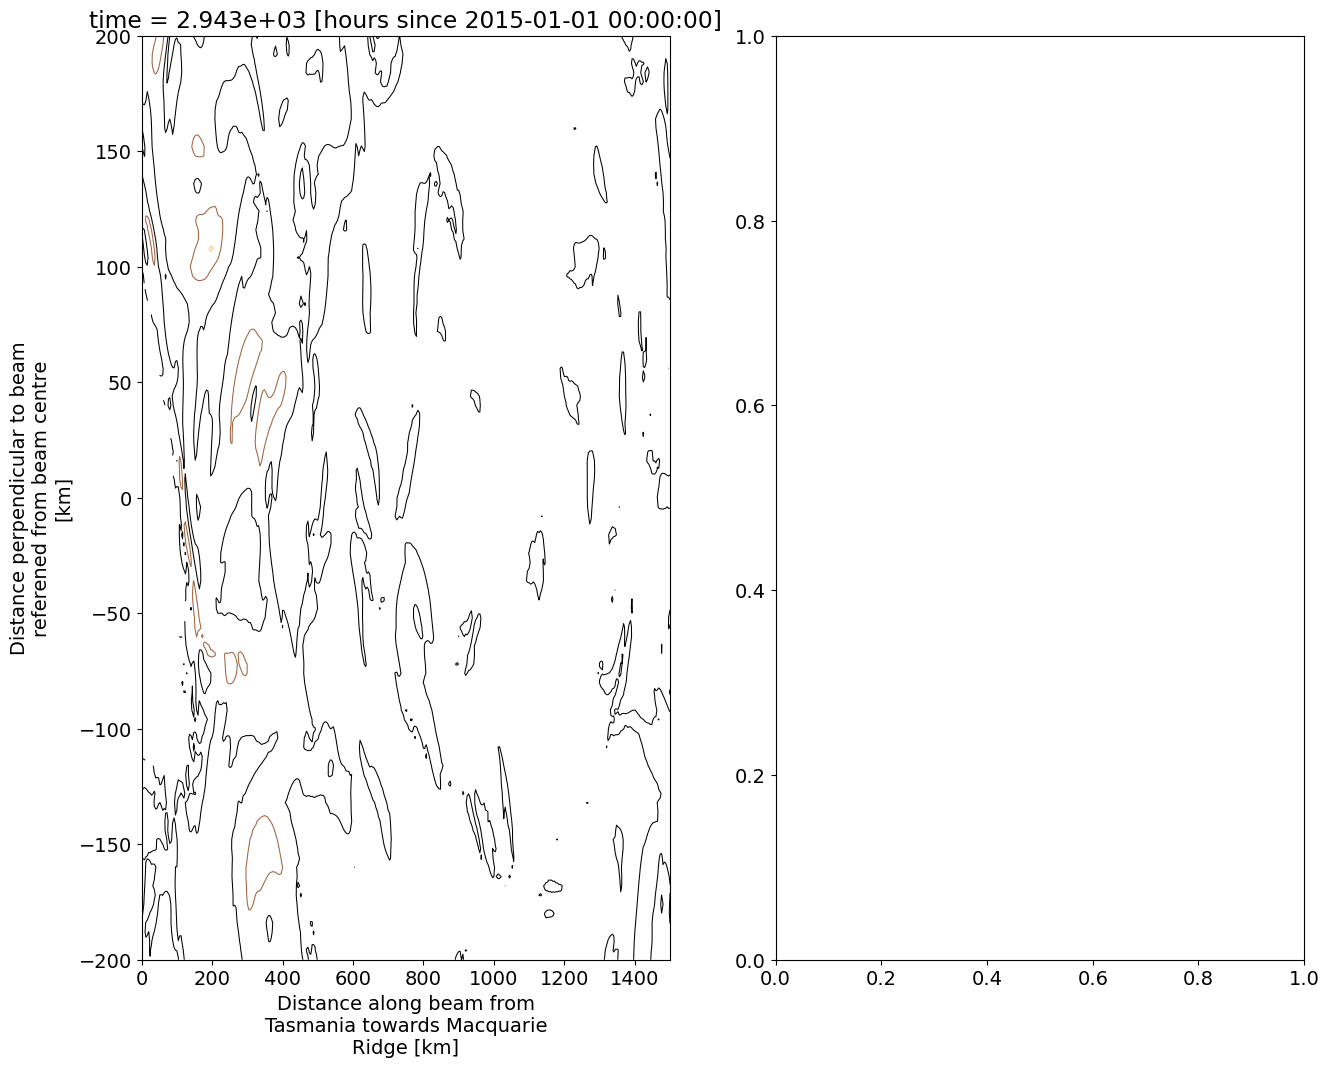

In [67]:
fig,ax = plt.subplots(1,2,figsize = (15,12))
speed.isel(time = 10).plot.contour(ax = ax[0],levels = [0.25,0.75,1],cmap = "copper",lineweight = 0.5,vmin = 0.25,vmax = 1,linewidths = 0.75)


/jobfs/102108164.gadi-pbs/ipykernel_741604/868658201.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('RdBu')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xarray/plot/dataarray_plot.py:2026: UserWarning: The following kwargs were not used by contour: 'lineweight'
  primitive = ax.contour(x, y, z, **kwargs)


Text(0.5, 1.0, 'Transect along middle of beam')

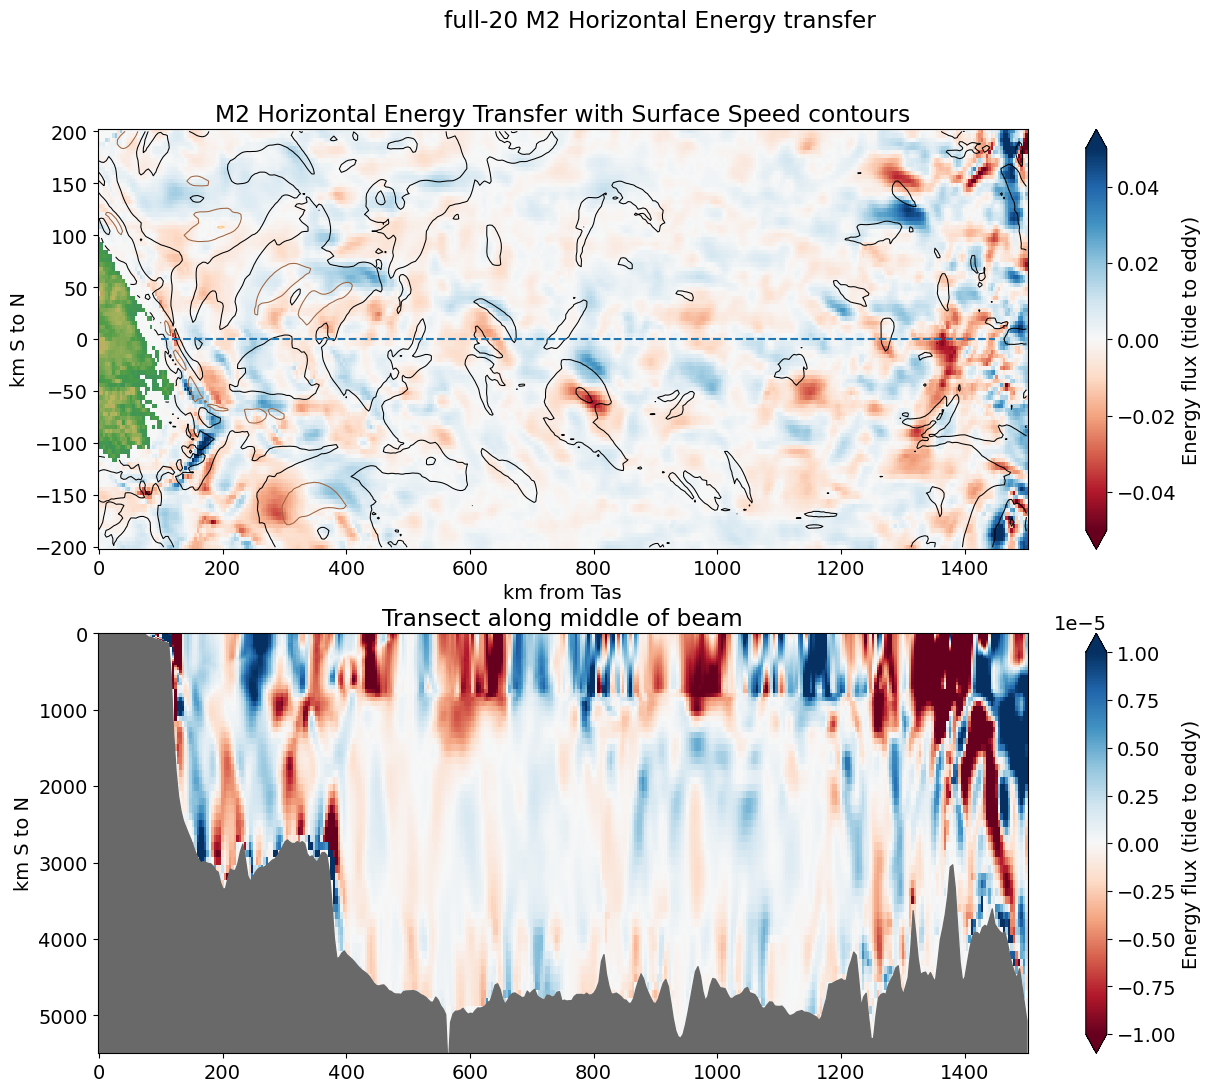

In [63]:
exptname = "full-20"
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
# hef = tt.hef(u,v,0,total_only = True).persist()

cmap = matplotlib.cm.get_cmap('RdBu')
cmap.set_bad("green")
speed.isel(time = 10).plot.contour(ax = ax[0],levels = [0.25,0.75,1],cmap = "copper",lineweight = 0.5,vmin = 0.25,vmax = 1,linewidths = 0.75)
hef.integrate("zl").isel(time = 0).plot(ax = ax[0],cmap = cmap,vmin = -0.05,vmax = 0.05,cbar_kwargs={'label': "Energy flux (tide to eddy)"})

## Add bathymetry plot
tt.plot_topo(ax[0],bathy)


## Second axis: vertical transect
hef.isel(time = 0).sel(yb = 0,method = "nearest").plot(ax = ax[1],cmap = cmap,vmin = -0.00001,vmax = 0.00001,cbar_kwargs={'label': "Energy flux (tide to eddy)"})
tt.plot_topo(ax[1],bathy,transect = 0)
fig.suptitle(exptname + " M2 Horizontal Energy transfer")
ax[1].invert_yaxis()
ax[0].set_xlabel('km from Tas')
ax[0].set_ylabel('km S to N')
ax[0].set_title('M2 Horizontal Energy Transfer with Surface Speed contours')
## put gridlines on plot
# ax[0].grid(True, which='both')
ax[0].hlines(y = 0,xmin = 100,xmax = 1450,linestyles = "dashed")
ax[1].set_xlabel('')
ax[1].set_ylabel('km S to N')
ax[1].set_title('Transect along middle of beam')


<Axes: >

<Figure size 640x480 with 0 Axes>

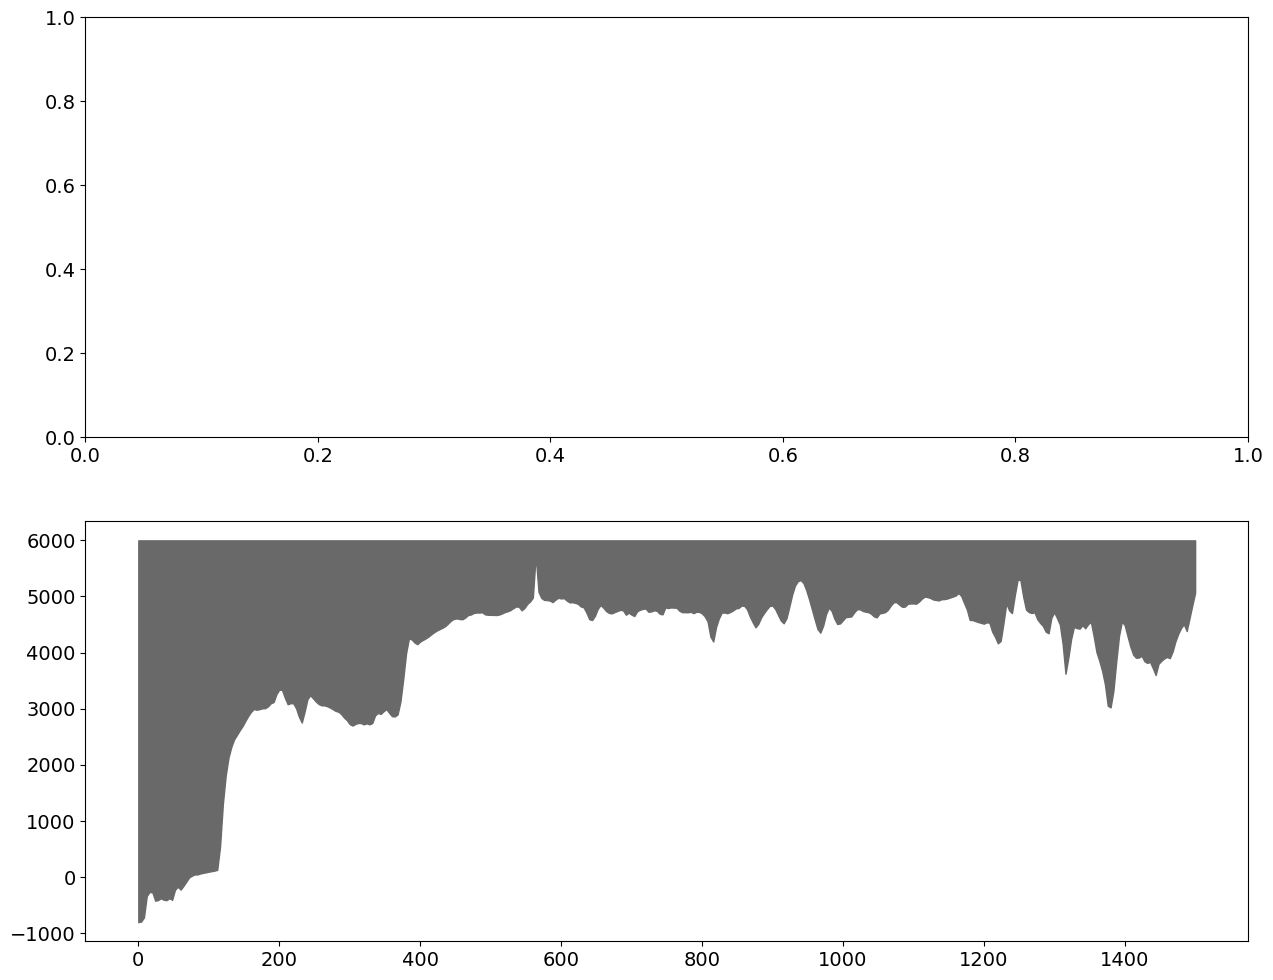

In [23]:
reload(tt)
plt.clf()
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
tt.plot_topo(ax[1],bathy,transect = 0)


<Figure size 640x480 with 0 Axes>

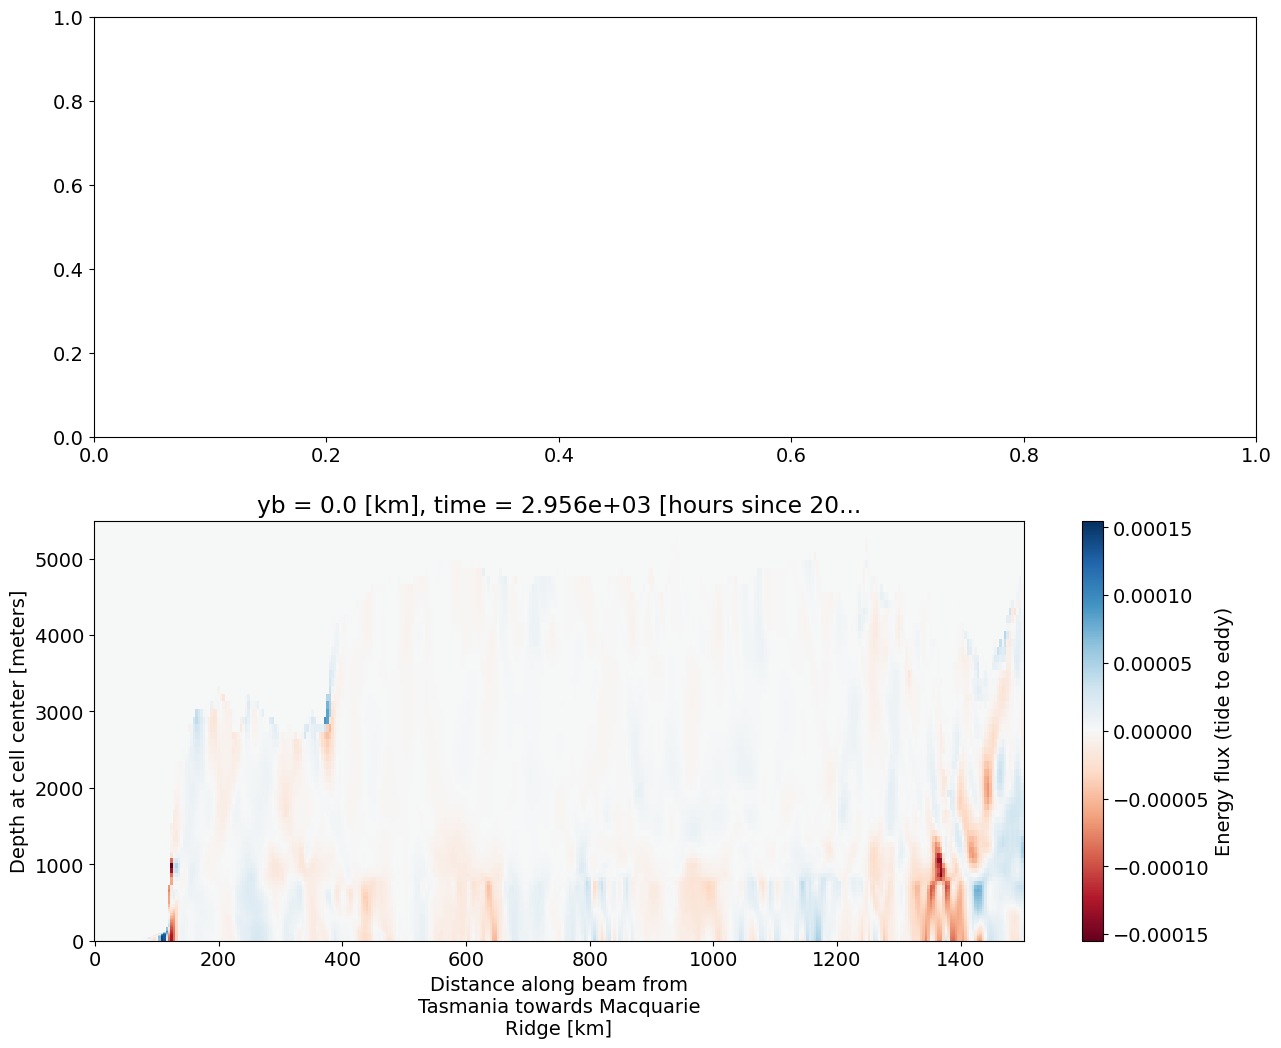

In [94]:
plt.clf()
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
hef.isel(time = 0).sel(yb = 0,method = "nearest").plot(ax = ax[1],cmap = cmap,cbar_kwargs={'label': "Energy flux (tide to eddy)"})

## Temporally filter outputs 

Filter in chunks of 10 tidal periods, staggered over 5 tidal periods. The overlaps will be averaged

i.e

i = 0
previous data = array of zeros
loop:
1. new data = Filter from `t=i` until `i+10` tidal periods
2. previous data = mean (previous data , new data)
3. save previous data somewhere
4. previous data = new data

Continue until we run out of complete 10 tidal period chunks of data. Then, save the last 5 tidal periods as the final part of time series.



/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


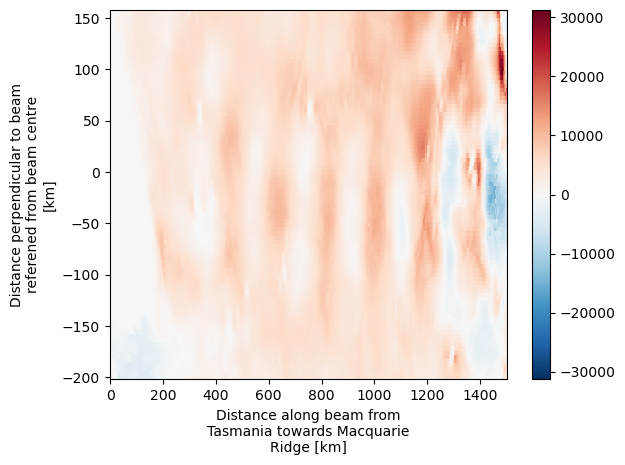

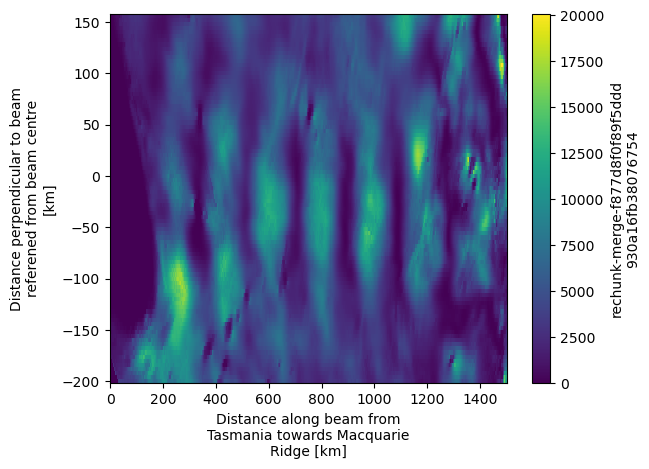

In [20]:
uf = filter(
    u.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(50,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
vf = filter(
    v.sel(
        time = slice(213361,213361 + m2 * 12)
        ).isel(zl = slice(50,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
(uf * vf).mean("time").plot()
plt.figure()
(uf * uf).mean("time").plot()


In [38]:
m2 = 360 / 28.984104 ## Period of m2 in hours
m2f = 1/ m2    ## Frequency of m2 in radians per hour
tol = 0.015    ## tolorance matching Waterhouse (1.9 cpd +- 0.4 cpd ~ m2f +- 0.015 rad/hr)
t0 = 213361
i = 0
u = u.fillna(0)
v = v.fillna(0)





/jobfs/101945186.gadi-pbs/ipykernel_535845/1977616080.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('cool')


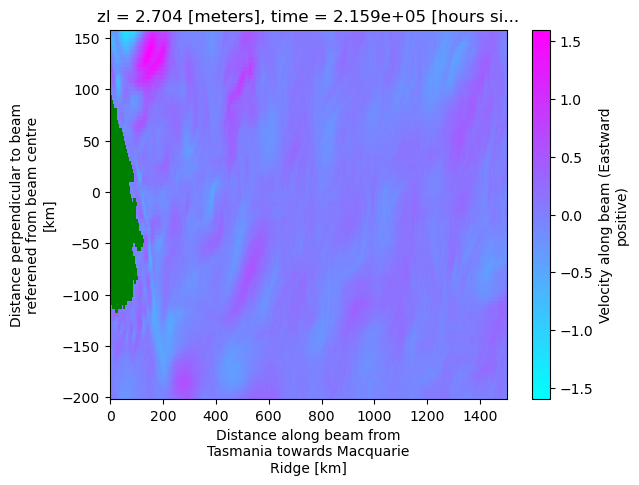

In [28]:
cmap = matplotlib.cm.get_cmap('cool')
cmap.set_bad("green")
u.isel(time = 0,zl = 0).plot(cmap = cmap)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.07/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/jobfs/101945186.gadi-pbs/ipykernel_535845/774718168.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('RdBu')


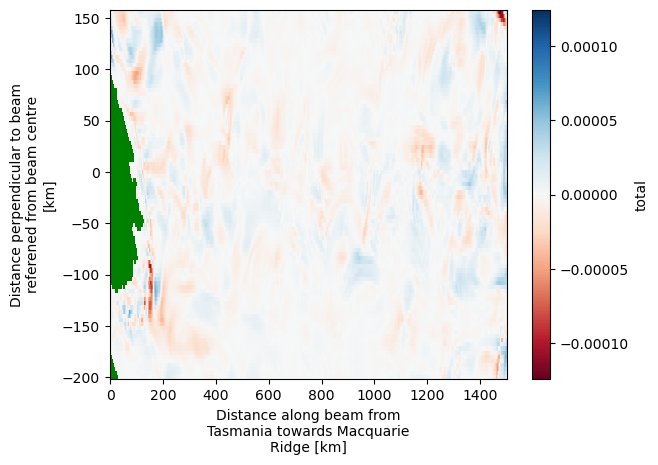

In [50]:
a = hef(u,v,1).persist()
b = a
# b = a.where(bathy != 0.0)
cmap = matplotlib.cm.get_cmap('RdBu')
cmap.set_bad("green")
b = b.total.mean("zl")

b.where(b != 0).plot(cmap = cmap)
# b.values

<xarray.Dataset>
Dimensions:       (zl: 100, xb: 376, yb: 90)
Coordinates:
  * zl            (zl) float64 2.704 8.126 13.58 ... 5.339e+03 5.443e+03
  * xb            (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb            (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 148.0 152.0 156.0
Data variables:
    nstress_u     (zl, yb, xb) float64 dask.array<chunksize=(100, 10, 376), meta=np.ndarray>
    nstress_v     (zl, yb, xb) float64 dask.array<chunksize=(100, 10, 376), meta=np.ndarray>
    n_strain      (zl, yb, xb) float32 dask.array<chunksize=(100, 10, 376), meta=np.ndarray>
    shear         (zl, yb, xb) float64 dask.array<chunksize=(100, 10, 376), meta=np.ndarray>
    shear_strain  (zl, yb, xb) float32 dask.array<chunksize=(100, 10, 376), meta=np.ndarray>
    total         (zl, yb, xb) float64 dask.array<chunksize=(100, 10, 376), meta=np.ndarray>

surface...


Text(0.5, 1.0, 'Surface Speed')

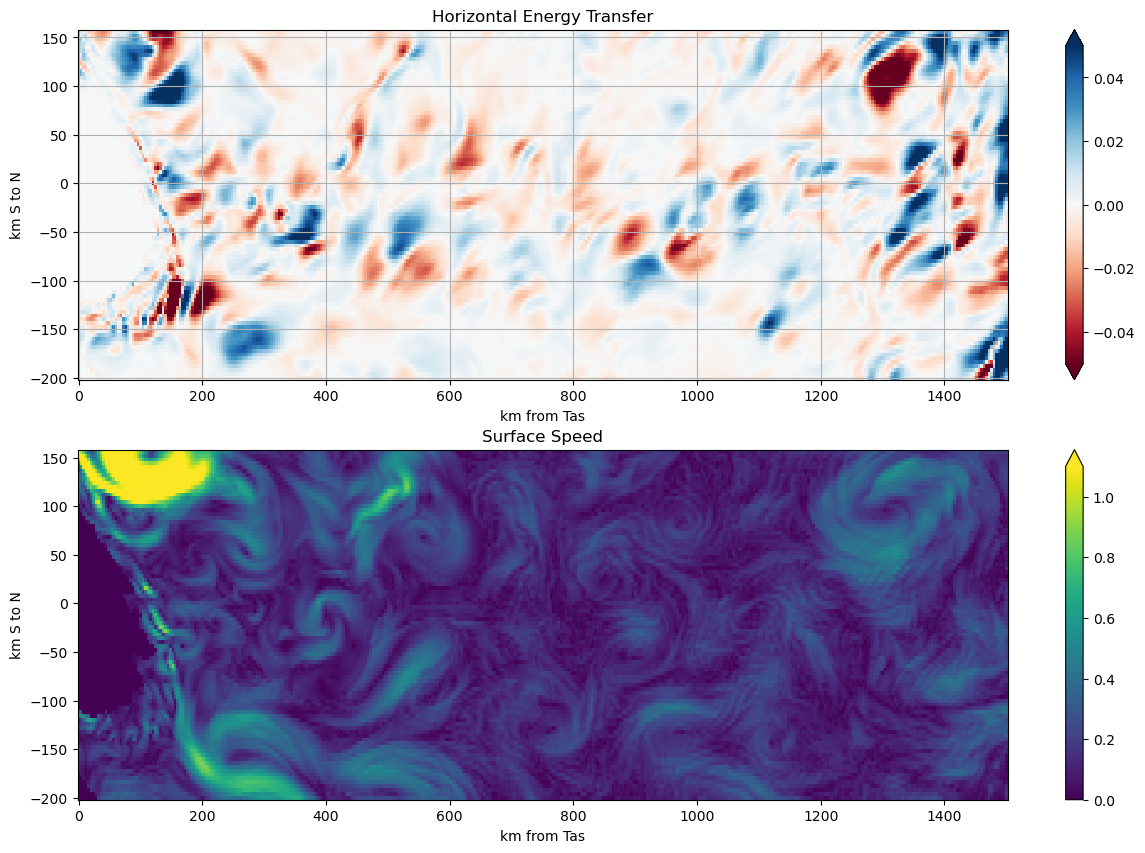

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# total = hef(u,v,10).persist()
total.plot(ax = axs[0],vmin = -0.05,vmax = 0.05,cmap = "RdBu")
# total.mean("yb").cumsum("xb").plot(ax = axs[0])

axs[0].set_xlabel('km from Tas')
axs[0].set_ylabel('km S to N')
axs[0].set_title('Horizontal Energy Transfer')
print("surface...")
## put gridlines on plot
axs[0].grid(True, which='both')
# speed = np.sqrt(u**2 + v**2).sel(time = t0 + i + m2 * 6,method = "nearest").isel(zl = 0).persist()
speed.plot(ax = axs[1],vmax = 1.1)
axs[1].set_xlabel('km from Tas')
axs[1].set_ylabel('km S to N')
axs[1].set_title('Surface Speed')


In [5]:

for i in range(10,30):
    print(i)
    fig, axs = plt.subplots(2, 1, figsize=(15, 10))

    total = hef(u,v,i).persist()
    total.plot(ax = axs[0],vmin = -0.2,vmax = 0.2,cmap = "RdBu")
    axs[0].set_xlabel('km from Tas')
    axs[0].set_ylabel('km S to N')
    axs[0].set_title('Horizontal Energy Transfer')
    # print("surface...")
    speed = np.sqrt(u**2 + v**2).sel(time = t0 + i + m2 * 6,method = "nearest").isel(zl = 0).persist()
    speed.plot(ax = axs[1])
    axs[1].set_xlabel('km from Tas')
    axs[1].set_ylabel('km S to N')
    axs[1].set_title('Surface Speed')
    plt.savefig(f"/g/data/v45/ab8992/dropbox/regional_movies/hef{i}.png")
    plt.clf()

10


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

11


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

12


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

13


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

14


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

15


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

16


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 185.96 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-pac

2023-11-14 10:12:14,184 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:42305'.
2023-11-14 10:12:14,187 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36689'.
2023-11-14 10:12:14,189 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:35049'.
2023-11-14 10:12:14,191 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:33375'.
2023-11-14 10:12:14,193 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43967'.
2023-11-14 10:12:14,194 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:43283'.
2023-11-14 10:12:14,197 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:39359'.


In [29]:
ke = (uf**2 + vf**2).integrate("zl").mean("time").persist()

2023-11-13 17:21:19,581 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 13.13 GiB -- Worker memory limit: 16.00 GiB
2023-11-13 17:21:20,044 - distributed.worker.memory - WARNING - Worker is at 55% memory usage. Resuming worker. Process memory: 8.88 GiB -- Worker memory limit: 16.00 GiB


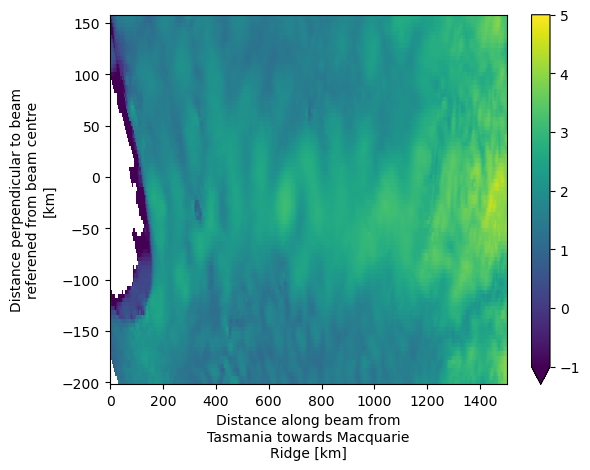

In [30]:
np.log(ke).plot(vmax = 5,vmin = -1)

In [20]:
uf

<xarray.DataArray 'rechunk-merge-5d41647d0fe4ba16cd18177763f53fbc' (time: 150,
                                                                    zl: 100,
                                                                    yb: 90,
                                                                    xb: 376)>
dask.array<real, shape=(150, 100, 90, 376), dtype=float64, chunksize=(150, 100, 10, 376), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 148.0 152.0 156.0
    lat      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
    lon      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
  * time     (time) float64 2.134e+05 2.134e+05 ... 2.135e+05 2.135e+05

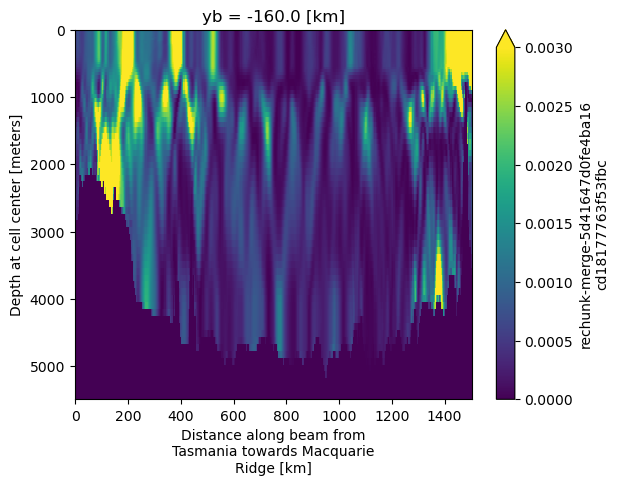

In [17]:
(uf**2).isel(yb = 10).mean("time").plot(vmax = 0.003)
## invert the y axis of existing plot
plt.gca().invert_yaxis()
# bathy.isel(yb = 10).plot()


## Repeat for blank

In [29]:
output = "0*"
surface = xr.open_mfdataset(f"/g/data/nm03/ab8992/blank-20/output{output}/surface.nc",decode_times = False)
u = xr.open_mfdataset(f"/g/data/nm03/ab8992/blank-20/output{output}/u/*",decode_times = False).u
v = xr.open_mfdataset(f"/g/data/nm03/ab8992/blank-20/output{output}/v/*",decode_times = False).v
e = xr.open_mfdataset(f"/g/data/nm03/ab8992/blank-20/output{output}/e/*",decode_times = False).e
rho = xr.open_mfdataset(f"/g/data/nm03/ab8992/blank-20/output{output}/rho/*",decode_times = False).rho
bathy = e.isel(time = 0,rho2_i = 0)

In [39]:
u.time.values[0]

212641.0

In [40]:
u.sel(
        time = slice(212641.0,212641.0 + m2 * 12)
        )

<xarray.DataArray 'u' (time: 150, zl: 100, yb: 90, xb: 376)>
dask.array<getitem, shape=(150, 100, 90, 376), dtype=float32, chunksize=(150, 100, 10, 376), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 2.704 8.126 13.58 ... 5.236e+03 5.339e+03 5.443e+03
  * time     (time) float64 2.126e+05 2.126e+05 ... 2.128e+05 2.128e+05
  * xb       (xb) float64 -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 -200.0 -196.0 -192.0 -188.0 ... 148.0 152.0 156.0
    lat      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
    lon      (yb, xb) float64 dask.array<chunksize=(10, 376), meta=np.ndarray>
Attributes:
    long_name:  Velocity along beam (Eastward positive)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


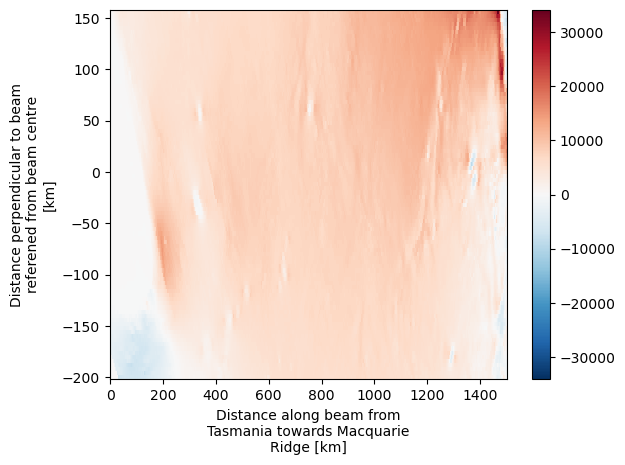

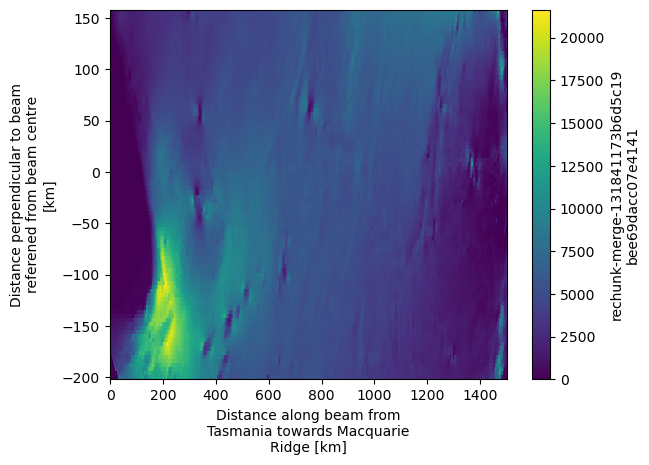

In [41]:
uf = filter(
    u.sel(
        time = slice(212641.0,212641.0 + m2 * 12)
        ).isel(zl = slice(0,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
vf = filter(
    v.sel(
        time = slice(212641.0,212641.0 + m2 * 12)
        ).isel(zl = slice(0,None)).integrate("zl").drop(["lat","lon"]),
    m2f)
(uf * vf).mean("time").plot()
plt.figure()
(uf * uf).mean("time").plot()


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


surface...


Text(0.5, 1.0, 'Surface Speed')

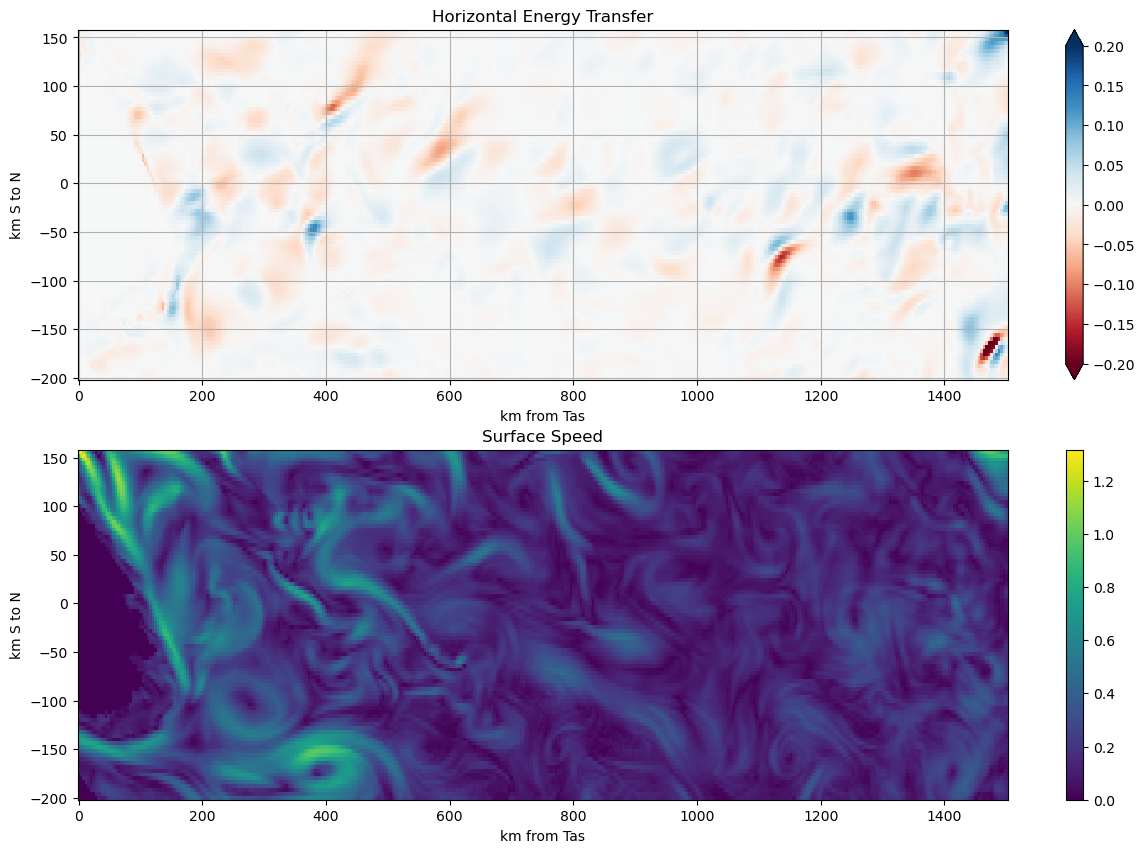

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
i = 0
total = hef(u,v,10).persist()
total.plot(ax = axs[0],vmin = -0.2,vmax = 0.2,cmap = "RdBu")
# total.mean("yb").cumsum("xb").plot(ax = axs[0])

axs[0].set_xlabel('km from Tas')
axs[0].set_ylabel('km S to N')
axs[0].set_title('Horizontal Energy Transfer')
print("surface...")
## put gridlines on plot
axs[0].grid(True, which='both')
speed = np.sqrt(u**2 + v**2).sel(time = t0 + i + m2 * 6,method = "nearest").isel(zl = 0).persist()
speed.plot(ax = axs[1])
axs[1].set_xlabel('km from Tas')
axs[1].set_ylabel('km S to N')
axs[1].set_title('Surface Speed')
